### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [ ]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

### Load and visualize data

*   categories.npy
*   training_data.npy
*   valid_periods.npy

In [ ]:
categories = np.load('categories.npy')
training_data = np.load('training_data.npy')
valid_periods = np.load('valid_periods.npy')
print(f"categories shape: {categories.shape} , Type: {categories.dtype}")
print(f"training_data shape: {training_data.shape} , Type: {training_data.dtype}")
print(f"valid_periods shape: {valid_periods.shape} , Type: {valid_periods.dtype}")

categories shape: (48000,) , Type: <U1
training_data shape: (48000, 2776) , Type: float64
valid_periods shape: (48000, 2) , Type: int64


In [ ]:
# count unique classes
num_classes = len(np.unique(categories))
print(f"Numero di classi uniche: {num_classes}")

# count number elements for each class
class_counts = pd.Series(categories).value_counts()
print("\nNumero di elementi per classe:")
print(class_counts)

Numero di classi uniche: 6

Numero di elementi per classe:
B    10987
E    10975
C    10017
D    10016
A     5728
F      277
dtype: int64


####Basic data visualization

In [ ]:
print("categories: ")
print(categories[:5])  # Visualize first 5 rows

print("\ntraining_data: ")
print(training_data[0:5])  # Visualize first 5 rows

print("\nvalid_periods: ")
print(valid_periods[:5])  # Visualize first 5 rows


categories: 
['D' 'D' 'D' 'D' 'D']

training_data: 
[[0.         0.         0.         ... 0.60277778 0.36759259 0.33148148]
 [0.         0.         0.         ... 0.6        0.46       0.396     ]
 [0.         0.         0.         ... 0.96048126 0.94650625 0.97714021]
 [0.         0.         0.         ... 0.47058824 0.56958393 0.57101865]
 [0.         0.         0.         ... 0.72727273 0.81818182 0.84090909]]

valid_periods: 
[[2325 2776]
 [2325 2776]
 [2325 2776]
 [2712 2776]
 [2682 2776]]


In [ ]:
# ARE '0.' MISSING VALUES?
# Itera attraverso ciascuna serie temporale
count_inv=0
for i in range(len(categories)):
    # Ottieni gli indici di inizio e fine del periodo valido
    start_index, end_index = valid_periods[i]

    # Estrai la parte dei dati di addestramento compresa tra i periodi validi
    selected_data = training_data[i, start_index:end_index]

    # Verifica la presenza di valori mancanti (NaN) o valori uguali a 0
    if np.isnan(selected_data).any() or (selected_data == 0).any():
        count_inv=count_inv+1
print(count_inv)

40223


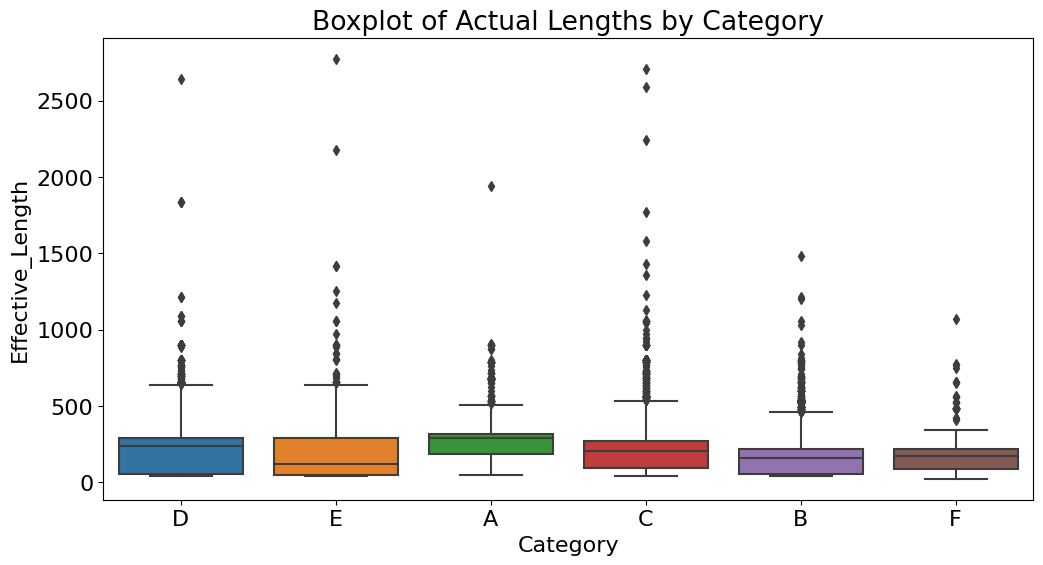

In [ ]:
# Calcola la lunghezza effettiva delle serie temporali senza il padding
effective_lengths = valid_periods[:, 1] - valid_periods[:, 0]

# Crea un DataFrame per analisi più agevoli
df = pd.DataFrame({'Category': categories, 'Effective_Length': effective_lengths})

# Boxplot delle lunghezze effettive per categoria
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='Effective_Length', data=df)
plt.title('Boxplot of Actual Lengths by Category')
plt.show()

In [ ]:
count_values_below_100 = np.count_nonzero(effective_lengths < 51)
print(len(effective_lengths))
print(count_values_below_100)

48000
2504


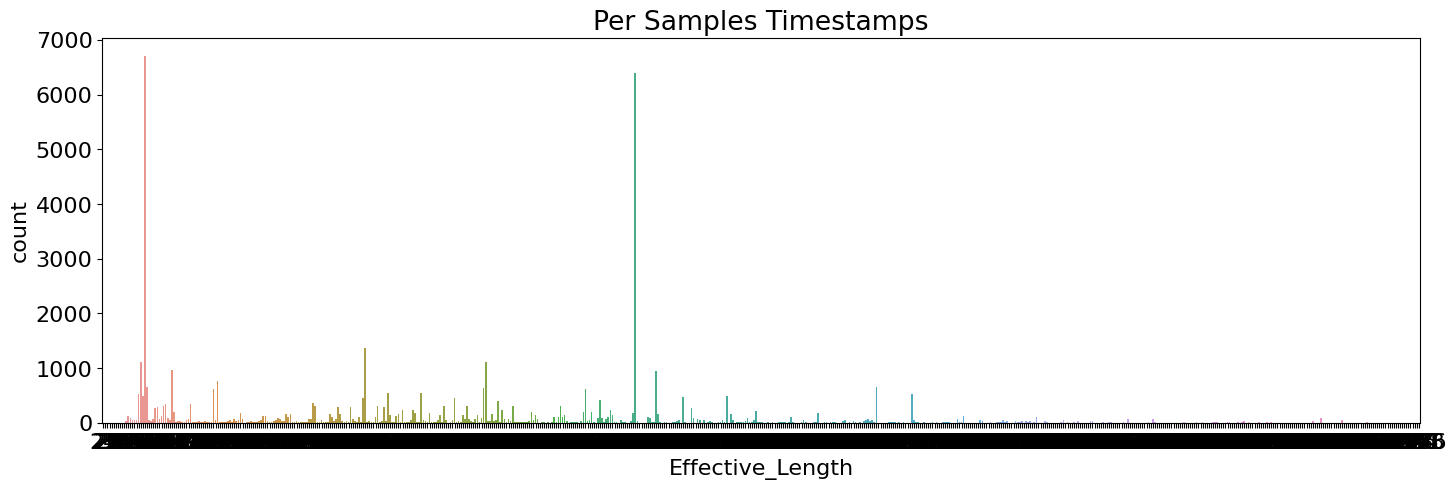

In [ ]:
# Inspect users timestamps
plt.figure(figsize=(17,5))
sns.countplot(x = 'Effective_Length', data = df)
plt.title('Per Samples Timestamps')
plt.show()

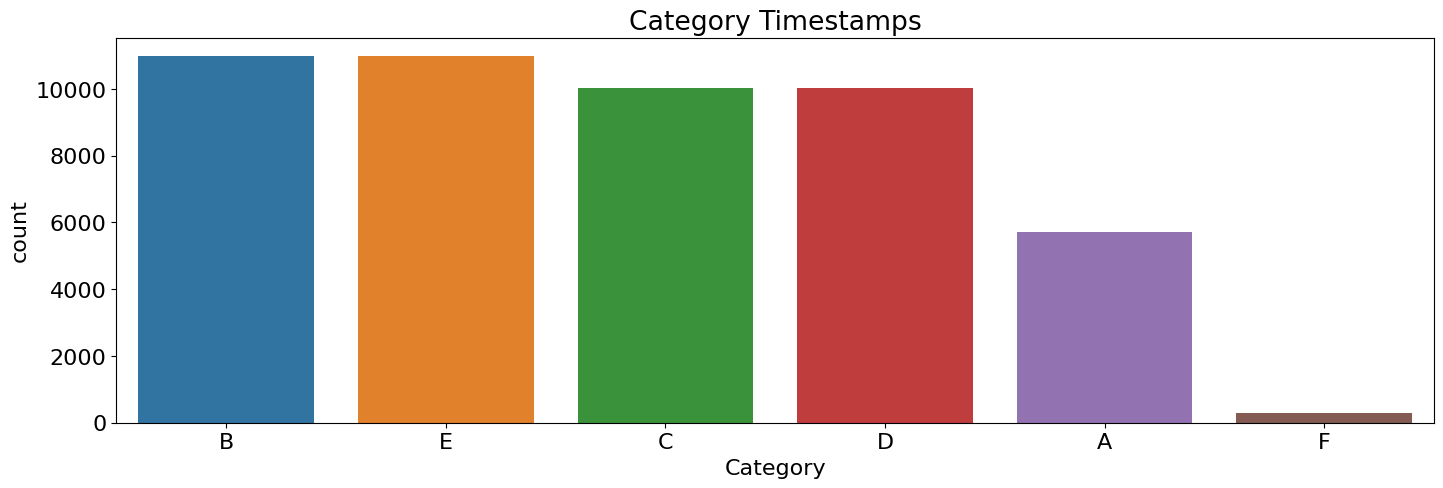

In [ ]:
# Inspect activities timestamps
plt.figure(figsize=(17,5))
sns.countplot(x = 'Category', data = df, order = df['Category'].value_counts().index)
plt.title('Category Timestamps')
plt.show()

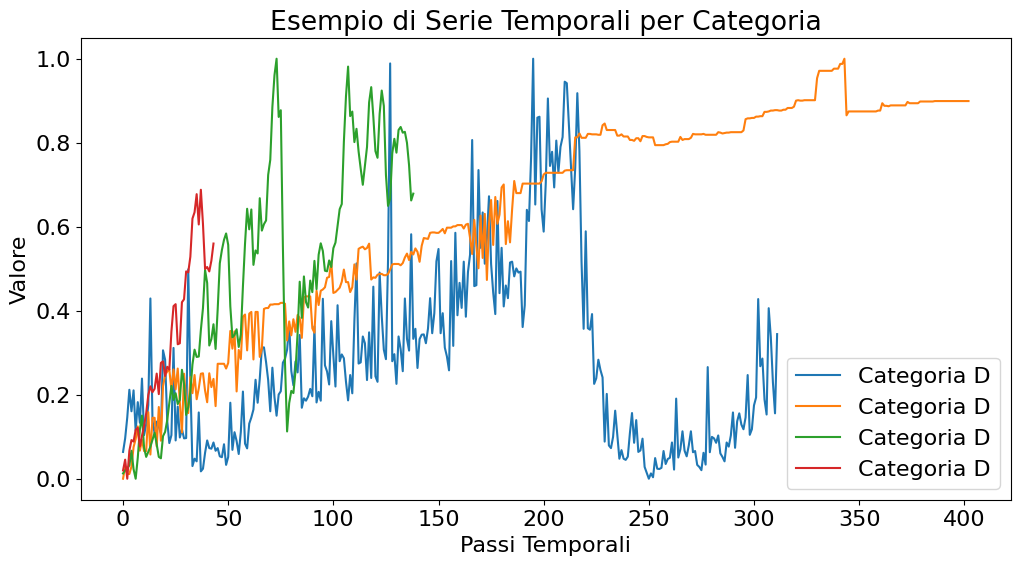

In [ ]:
# choose timeseries indexes
sample_indices = [1033, 114, 142, 413]

# visualize
plt.figure(figsize=(12, 6))
for idx in sample_indices:
    start, end = valid_periods[idx]
    plt.plot(training_data[idx, start:end])
plt.title('Esempio di Serie Temporali per Categoria')
plt.xlabel('Passi Temporali')
plt.ylabel('Valore')
plt.legend([f'Categoria {categories[idx]}' for idx in sample_indices])
plt.show()


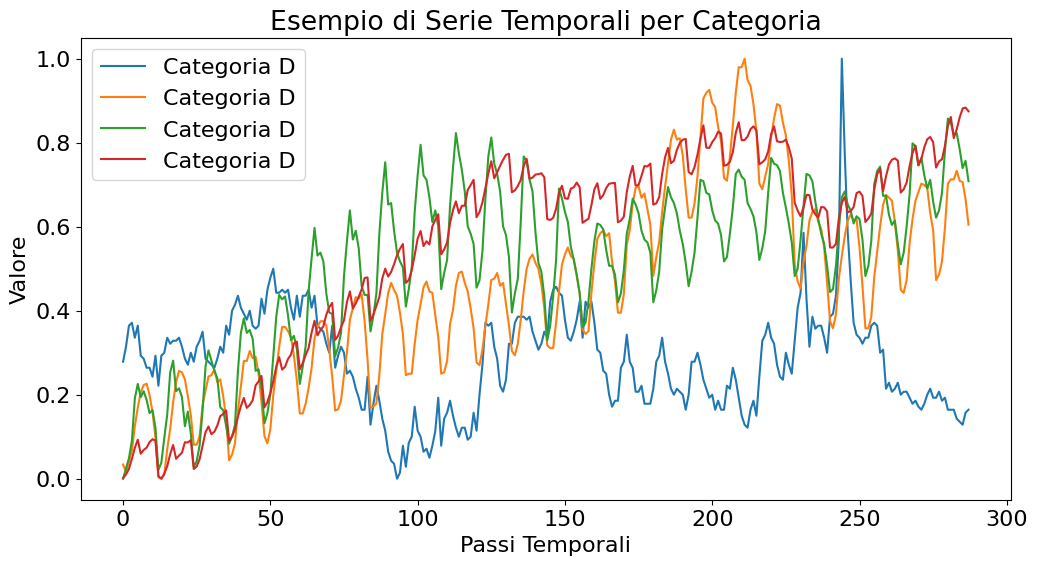

In [ ]:
# choose timeseries indexes
sample_indices = [1100, 1600, 1300, 1545]

# Visualizza solo la parte effettiva delle serie temporali di esempio
plt.figure(figsize=(12, 6))
for idx in sample_indices:
    start, end = valid_periods[idx]
    plt.plot(training_data[idx, start:end])
plt.title('Esempio di Serie Temporali per Categoria')
plt.xlabel('Passi Temporali')
plt.ylabel('Valore')
plt.legend([f'Categoria {categories[idx]}' for idx in sample_indices])
plt.show()

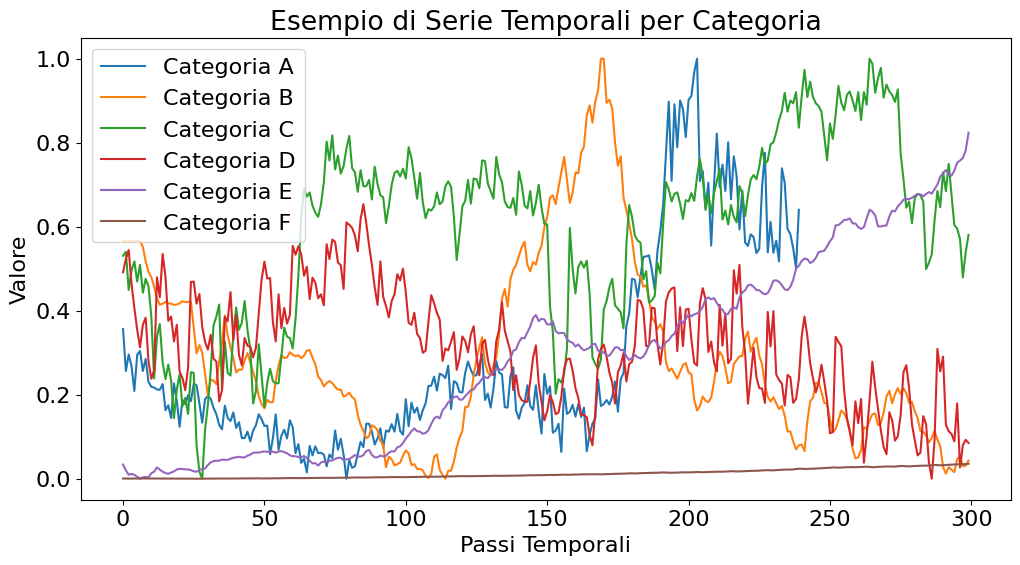

In [ ]:
# Ottenere le categorie uniche
unique_categories = np.unique(categories)

# Numero di serie temporali di esempio per categoria
num_samples_per_category = 1

# Visualizza serie temporali di esempio per ogni categoria
plt.figure(figsize=(12, 6))
for category in unique_categories:
    # Trova gli indici delle serie temporali nella categoria corrente
    category_indices = np.where(categories == category)[0]

    # Scegli un numero specifico di serie temporali di esempio per questa categoria
    category_sample_indices = category_indices[:num_samples_per_category]

    # Visualizza solo la parte effettiva delle serie temporali di esempio
    for idx in category_sample_indices:
        start, end = valid_periods[idx]
        plt.plot(training_data[idx, start:start+300]) #FISSATA LUNGHEZZA DA VISUALIZZARE

plt.title('Esempio di Serie Temporali per Categoria')
plt.xlabel('Passi Temporali')
plt.ylabel('Valore')
plt.legend([f'Categoria {category}' for category in unique_categories])
plt.show()


Timeseries Decomposition



time series analysis:

1.   https://medium.com/analytics-vidhya/interpreting-acf-or-auto-correlation-plot-d12e9051cd14
2.   https://dganais.medium.com/autocorrelation-in-time-series-c870e87e8a65
3. https://otexts.com/fpp2/autocorrelation.html
4. https://towardsdatascience.com/time-series-diy-seasonal-decomposition-f0b469afed44




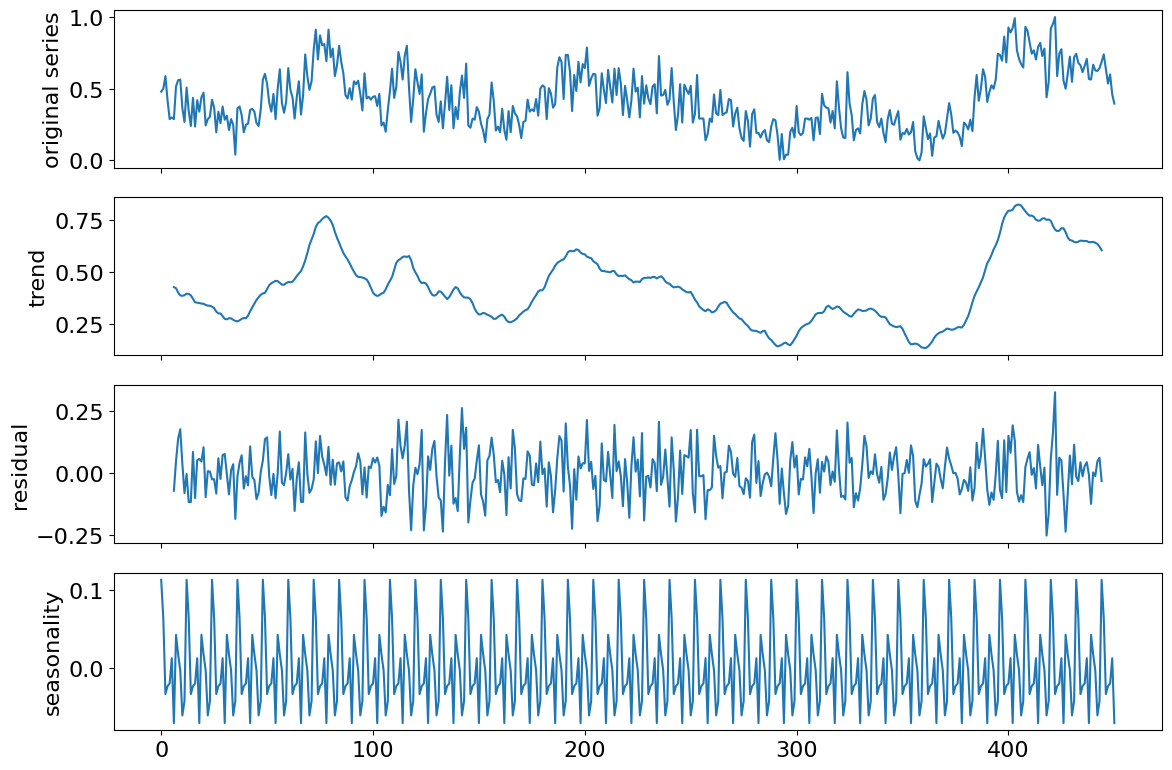

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

selected_series = 1

start_index, end_index = valid_periods[selected_series]

temporal_series = training_data[selected_series, start_index:end_index]

temporal_series = pd.Series(temporal_series)

res = seasonal_decompose(temporal_series, model="additive", period=12)

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(12, 8),sharex=True)
temporal_series.plot(ax=ax0, ylabel="original series")
res.trend.plot(ax=ax1, ylabel="trend")
res.resid.plot(ax=ax2, ylabel="residual")
res.seasonal.plot(ax=ax3, ylabel="seasonality")
plt.tight_layout()
plt.show()

####Autocorrelation analysis

using statsmodels.graphics.tsaplots

The first thing that we can do is to apply the autocorrelation function on the time series.
For some time series it s clear the seasonality (like for time series 1111), while for other it s more difficult to spot the seasonality because we should first detrend them (like for timeseries 1)

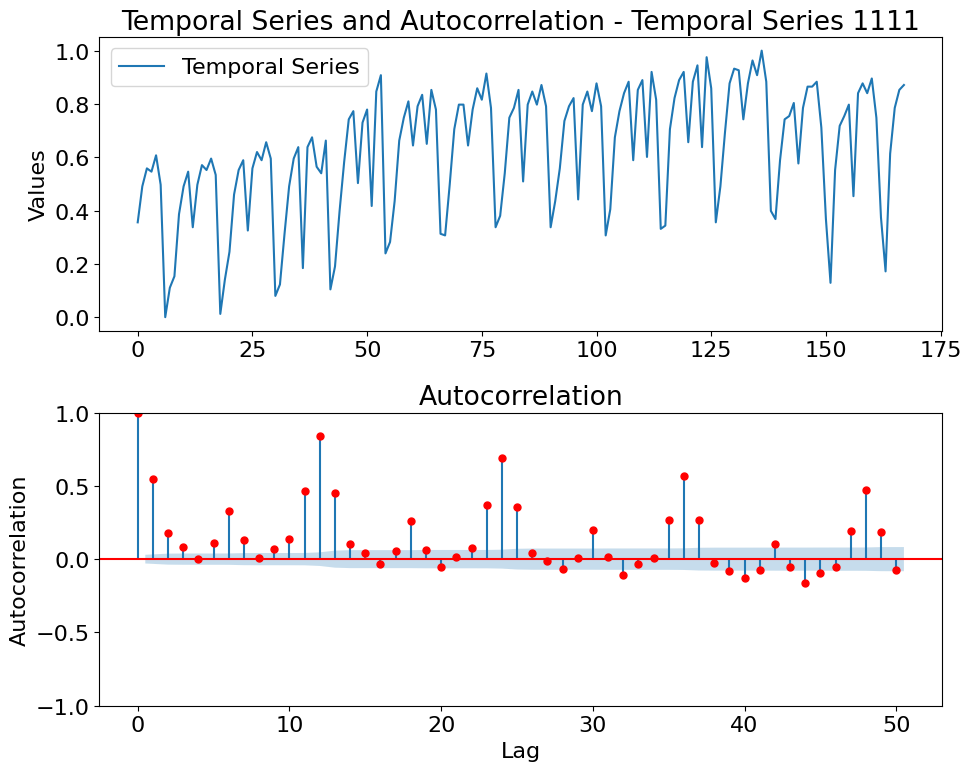

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

selected_series = 1111

start_index, end_index = valid_periods[selected_series]

temporal_series = training_data[selected_series, start_index:end_index]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

ax1.plot(temporal_series, label='Temporal Series')
ax1.set_ylabel('Values')

# Autocorrelation graph -Without detrending
plot_acf(temporal_series, lags=50, ax=ax2, color='red', alpha=0.7)
ax2.set_xlabel('Lag')
ax2.set_ylabel('Autocorrelation')

# Impostazioni del grafico
ax1.set_title(f'Temporal Series and Autocorrelation - Temporal Series {selected_series}')
ax1.legend()

plt.tight_layout()
plt.show()

One idea could be to make your time series stationary and then to perform ACF on it. One way to make a time series stationary is to compute the differences between consecutive observations. The ACF of the differenced signal should not suffer from the effects of trends or seasonality in the signal.

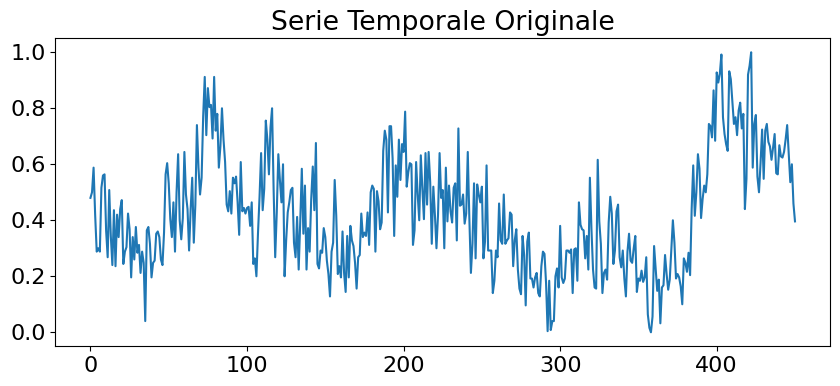

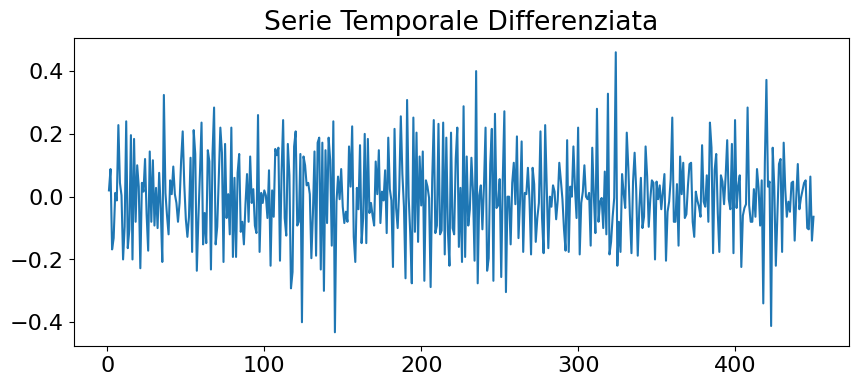

In [ ]:
# Scegli una serie temporale (ad esempio, la prima serie)
selected_series = 1

# Ottieni gli indici di inizio e fine del periodo valido per la serie selezionata
start_index, end_index = valid_periods[selected_series]

# Estrai la parte dei dati di addestramento compresa tra i periodi validi
temporal_series = training_data[selected_series, start_index:end_index]

# Converti la serie temporale in un oggetto pandas Series
temporal_series = pd.Series(temporal_series)

# Visualizza la serie temporale originale
plt.figure(figsize=(10, 4))
plt.plot(temporal_series)
plt.title('Serie Temporale Originale')
plt.show()

# Calcola le differenze tra le osservazioni consecutive
serie_differenziata = temporal_series.diff().dropna()

# Visualizza la serie temporale differenziata
plt.figure(figsize=(10, 4))
plt.plot(serie_differenziata)
plt.title('Serie Temporale Differenziata')
plt.show()


now you can see the seasonality period is more evident

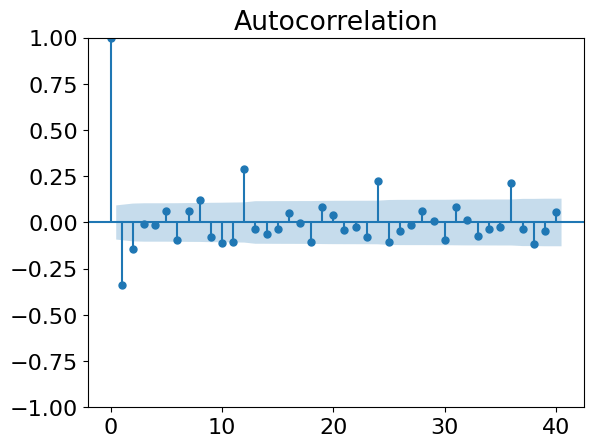

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

# Calcola l'ACF della serie differenziata
acf_result = acf(serie_differenziata, nlags=50, alpha=0.05)

# Visualizza l'ACF con gli intervalli di confidenza
plot_acf(serie_differenziata, lags=40, alpha=0.05)
plt.show()

# # Estrai i valori dell'ACF e gli intervalli di confidenza
# acf_values = acf_result[0]
# conf_int = acf_result[1]

# # Trova i massimi al di fuori dell'intervallo blu
# #significant_lags = [lag for lag, value in enumerate(acf_values) if value > conf_int[lag].any()]



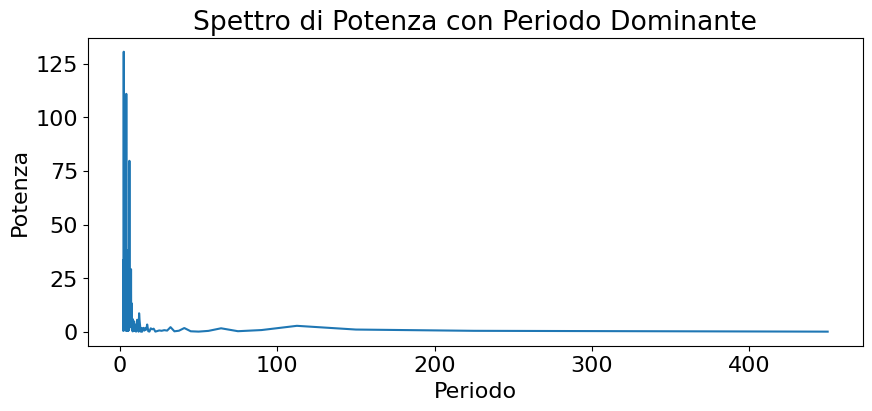

Periodo Dominante: 2.3936170212765955


In [ ]:
# # Calcola la trasformata di Fourier della serie temporale
# fft_result = np.fft.fft(serie_differenziata)

# # Calcola le frequenze associate alla trasformata di Fourier
# n = len(serie_differenziata)
# freq = np.fft.fftfreq(n, 1)  # Frequenze associate (inverso del periodo)

# # Filtra le frequenze positive (elimina la simmetria)
# positive_freq_mask = freq > 0
# freq = freq[positive_freq_mask]
# fft_result = fft_result[positive_freq_mask]

# # Calcola la potenza spettrale
# power_spectrum = np.abs(fft_result) ** 2

# # Trova la frequenza con la potenza massima
# dominant_frequency = freq[np.argmax(power_spectrum)]

# # Calcola il periodo associato alla frequenza dominante
# dominant_period = 1 / dominant_frequency

# # Visualizza lo spettro di potenza
# plt.figure(figsize=(10, 4))
# plt.plot(1 / freq, power_spectrum)  # Periodo inverso della frequenza
# plt.title('Spettro di Potenza con Periodo Dominante')
# plt.xlabel('Periodo')
# plt.ylabel('Potenza')
# plt.show()

# # Stampa il periodo dominante
# print("Periodo Dominante:", dominant_period)



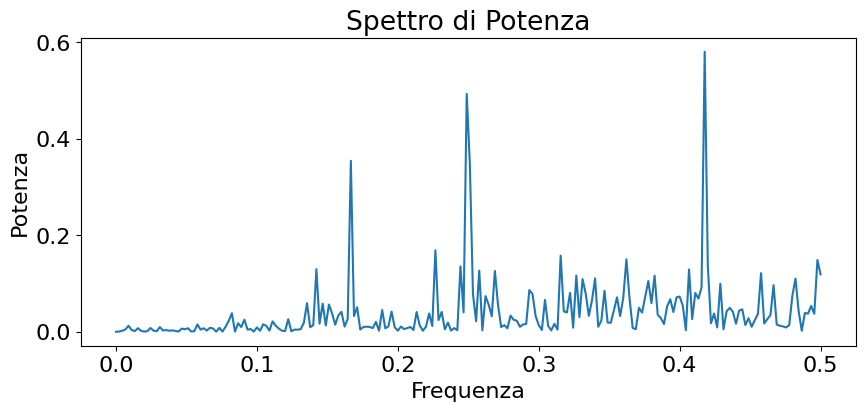

In [ ]:
# from scipy.signal import periodogram

# # Calcola lo spettro di potenza
# frequencies, power_spectrum = periodogram(serie_differenziata)

# # Visualizza lo spettro di potenza
# plt.figure(figsize=(10, 4))
# plt.plot(frequencies, power_spectrum)
# plt.title('Spettro di Potenza')
# plt.xlabel('Frequenza')
# plt.ylabel('Potenza')
# plt.show()


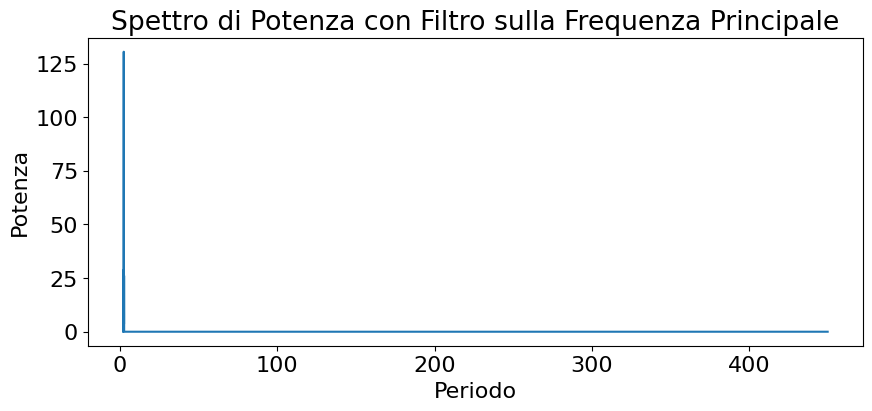

In [ ]:
# # Filtro per mantenere solo la frequenza principale
# main_frequency_mask = (freq > 0.9 * dominant_frequency) & (freq < 1.1 * dominant_frequency)
# filtered_fft_result = fft_result.copy()
# filtered_fft_result[~main_frequency_mask] = 0

# # Calcola la potenza spettrale con il filtro
# filtered_power_spectrum = np.abs(filtered_fft_result) ** 2

# # Visualizza lo spettro di potenza con il filtro
# plt.figure(figsize=(10, 4))
# plt.plot(1 / freq, filtered_power_spectrum)
# plt.title('Spettro di Potenza con Filtro sulla Frequenza Principale')
# plt.xlabel('Periodo')
# plt.ylabel('Potenza')
# plt.show()

### Split data

*   categories.npy
*   training_data.npy
*   valid_periods.npy

#### Split in Train-Test

In [ ]:
valid_indices = np.where(valid_periods[:,1]-valid_periods[:,0] <118)[0]
#print(len(valid_indices))
#print(valid_indices)
unique_indices = {category: np.where(categories == category)[0] for category in set(categories)}
#print(unique_indices)

In [ ]:
short_idx = indices[valid_periods[indices] < 118]
valid_indices = np.where(valid_periods[:,1]-valid_periods[:,0] <118)[0]

LONG AND SHORT DATASET-run this if you want to train a model only on timeseries that are longer than 118 (so you can use w=100,telescope=18 in order to avoid padding), and another model for shorter sequences (with w=40 and telescope=18).

we tried this approach to verify if the padding was affecting our results. So here we re trying to build 2 different model that are trained without padding, and at the end we do an ensamble with them.

Doing this, we re also hoping that the model with w=100 will learn long term properties of the network, while the shorter one on  short term fluctuations


In [ ]:
from sklearn.model_selection import train_test_split

# Crea un array di indici univoci per ogni classe
unique_indices = {category: np.where(categories == category)[0] for category in set(categories)}

# Inizializza gli array per i set di addestramento e test
train_indices_long = np.array([], dtype=int)
test_indices_long = np.array([], dtype=int)
val_indices_long = np.array([], dtype=int)

train_indices_short = np.array([], dtype=int)
test_indices_short = np.array([], dtype=int)
val_indices_short = np.array([], dtype=int)

# Divide il dataset in set di addestramento e test
for category, indices in unique_indices.items():
    short_indices = np.where(valid_periods[indices,1]-valid_periods[indices,0] <118)[0]
    long_indices = np.where(valid_periods[indices,1]-valid_periods[indices,0] >=118)[0]

    #SHORT
    # Utilizza train_test_split per dividere gli indici in set di addestramento e test
    train_idx, test_idx = train_test_split(short_indices, test_size=0.05, random_state=42)
    valid_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)
    # Aggiungi gli indici al risultato finale
    train_indices_short = np.concatenate((train_indices_short, train_idx))
    test_indices_short = np.concatenate((test_indices_short, test_idx))
    val_indices_short = np.concatenate((val_indices_short, valid_idx))

    #LONG
    # Utilizza train_test_split per dividere gli indici in set di addestramento e test
    train_idx, test_idx = train_test_split(long_indices, test_size=0.05, random_state=42)
    valid_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)
    # Aggiungi gli indici al risultato finale
    train_indices_long = np.concatenate((train_indices_long, train_idx))
    test_indices_long = np.concatenate((test_indices_long, test_idx))
    val_indices_long = np.concatenate((val_indices_long, valid_idx))

#SHORT
# Estrai i dati di addestramento e test utilizzando gli indici ottenuti
train_data_long = training_data[train_indices_long]
train_categories_long = categories[train_indices_long]
train_valid_periods_long = valid_periods[train_indices_long]

test_data_long = training_data[test_indices_long]
test_categories_long = categories[test_indices_long]
test_valid_periods_long = valid_periods[test_indices_long]

val_data_long = training_data[val_indices_long]
val_categories_long = categories[val_indices_long]
val_valid_periods_long = valid_periods[val_indices_long]

#LONG
# Estrai i dati di addestramento e test utilizzando gli indici ottenuti
train_data_short = training_data[train_indices_short]
train_categories_short = categories[train_indices_short]
train_valid_periods_short = valid_periods[train_indices_short]

test_data_short = training_data[test_indices_short]
test_categories_short = categories[test_indices_short]
test_valid_periods_short = valid_periods[test_indices_short]

val_data_short = training_data[val_indices_short]
val_categories_short = categories[val_indices_short]
val_valid_periods_short = valid_periods[val_indices_short]

ciao
ciao
ciao
ciao
ciao
ciao


In [ ]:
short_dataset_length= len(train_data_short)+len(test_data_short)+len(val_data_short)
long_dataset_length= len(train_data_long)+len(test_data_long)+len(val_data_long)
print(short_dataset_length)
print(long_dataset_length)
print(long_dataset_length+short_dataset_length)
print(len(train_categories_long)+len(test_categories_long)+len(val_categories_long))
print(len(train_categories_short)+len(test_categories_short)+len(val_categories_short))
print(len(test_valid_periods_long)+len(train_valid_periods_long)+len(val_valid_periods_long))
print(len(test_valid_periods_short)+len(train_valid_periods_short)+len(val_valid_periods_short))


16134
31866
48000
31866
16134
31866
16134


ONLY 1 DATASET - run this if you want the basic splitting version

In [ ]:
from sklearn.model_selection import train_test_split

# Crea un array di indici univoci per ogni classe
unique_indices = {category: np.where(categories == category)[0] for category in set(categories)}

# Inizializza gli array per i set di addestramento e test
train_indices = np.array([], dtype=int)
test_indices = np.array([], dtype=int)
val_indices = np.array([], dtype=int)

# Divide il dataset in set di addestramento e test
for category, indices in unique_indices.items():
    # Utilizza train_test_split per dividere gli indici in set di addestramento e test
    train_idx, test_idx = train_test_split(indices, test_size=0.05, random_state=42)
    valid_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=42)

    # Aggiungi gli indici al risultato finale
    train_indices = np.concatenate((train_indices, train_idx))
    test_indices = np.concatenate((test_indices, test_idx))
    val_indices = np.concatenate((val_indices, valid_idx))

# Estrai i dati di addestramento e test utilizzando gli indici ottenuti
train_data = training_data[train_indices]
train_categories = categories[train_indices]
train_valid_periods = valid_periods[train_indices]

test_data = training_data[test_indices]
test_categories = categories[test_indices]
test_valid_periods = valid_periods[test_indices]

val_data = training_data[val_indices]
val_categories = categories[val_indices]
val_valid_periods = valid_periods[val_indices]

In [ ]:
print(train_data.shape[0]+test_data.shape[0]) #check splitting

46801


In [ ]:
print(train_categories.shape[0]+test_categories.shape[0]) #check splitting

46801


In [ ]:
# Verifica la lunghezza totale per ogni categoria prima della divisione
original_lengths = {category: len(np.where(categories == category)[0]) for category in set(categories)}

# Verifica la lunghezza totale per ogni categoria dopo la divisione
train_lengths = {category: len(np.where(train_categories == category)[0]) for category in set(categories)}
test_lengths = {category: len(np.where(test_categories == category)[0]) for category in set(categories)}
val_lengths = {category: len(np.where(val_categories == category)[0]) for category in set(categories)}

# Stampa le lunghezze originali e dopo la divisione
for category in set(categories):
    print(f"Category {category}:")
    print(f"Original Length: {original_lengths[category]}")
    print(f"Length after splitting (train): {train_lengths[category]}")
    print(f"Length after splitting (val): {val_lengths[category]}")
    print(f"Length after splitting (test): {test_lengths[category]}")
    print()


Category A:
Original Length: 5728
Length after splitting (train): 5441
Length after splitting (val): 143
Length after splitting (test): 144

Category F:
Original Length: 277
Length after splitting (train): 263
Length after splitting (val): 7
Length after splitting (test): 7

Category E:
Original Length: 10975
Length after splitting (train): 10426
Length after splitting (val): 274
Length after splitting (test): 275

Category C:
Original Length: 10017
Length after splitting (train): 9516
Length after splitting (val): 250
Length after splitting (test): 251

Category B:
Original Length: 10987
Length after splitting (train): 10437
Length after splitting (val): 275
Length after splitting (test): 275

Category D:
Original Length: 10016
Length after splitting (train): 9515
Length after splitting (val): 250
Length after splitting (test): 251



#### Build sequences

In [ ]:
window = 100
stride = 5
telescope = 18

In [ ]:
print(train_data.shape)
print(train_valid_periods.shape)
print(train_categories.shape)

NameError: ignored

##### Robust Scaler


> Run this section to apply robust scaler. [dont forget to unscale the predictions]



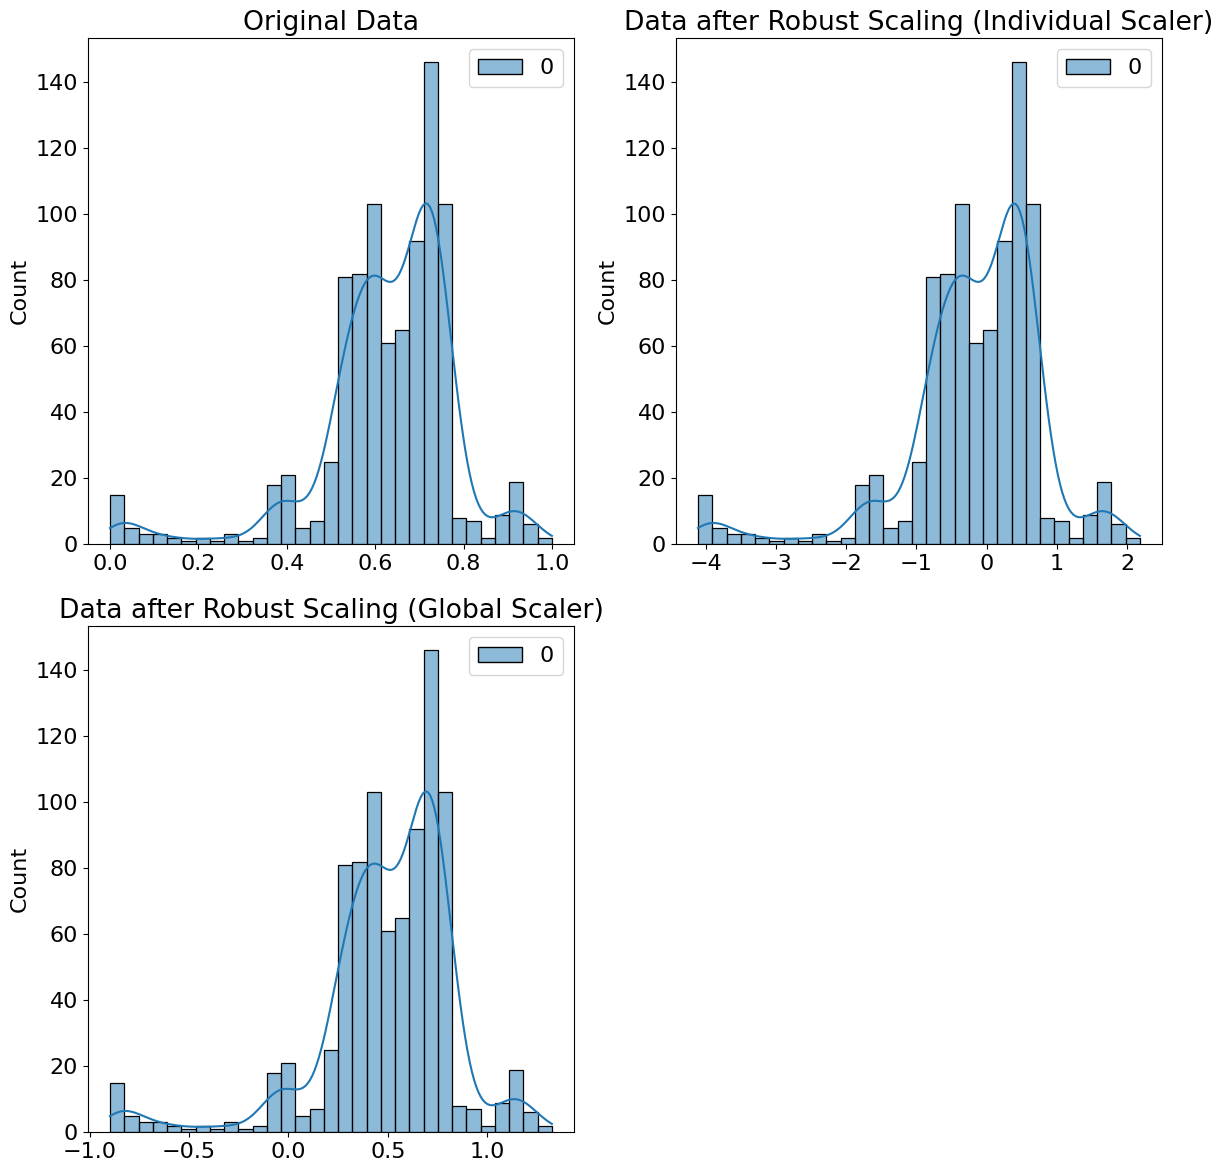

In [ ]:
#ROBUST SCALER: only on train_data. then we should use the same FITTER to the test_data, and deScaling the data after the prediction.

#FITTING THE ROBUST SCALER ON ALL TRAIN DATA
from sklearn.preprocessing import RobustScaler

# Inizializza il RobustScaler
global_robust_scaler = RobustScaler() #on all train set

# Estrai e concatena tutte le parti valide delle serie temporali
all_train_valid_timeseries = np.concatenate([train_data[i, start:end] for i, (start, end) in enumerate(train_valid_periods)])

# Fit del RobustScaler su tutti i dati
global_robust_scaler.fit(all_train_valid_timeseries.reshape(-1, 1))



# Scegli una serie temporale (ad esempio, la prima serie)
serie_temporale_selezionata = 12
# Ottieni gli indici di inizio e fine del periodo valido per la serie selezionata
start_index, end_index = valid_periods[serie_temporale_selezionata]
# Estrai la parte dei dati di addestramento compresa tra i periodi validi
serie_temporale = training_data[serie_temporale_selezionata, start_index:end_index]

individual_robust_scaler = RobustScaler()

# calculate median and IQR
individual_robust_scaler.fit(serie_temporale.reshape(-1, 1))

# scale all data points using median and IQR
robust_scaled_data = individual_robust_scaler.transform(serie_temporale.reshape(-1, 1))

robust_scaledtrained_data = global_robust_scaler.transform(serie_temporale.reshape(-1, 1))

# Stampa la serie originale
plt.figure(figsize=(12, 12))

# Plot per la serie originale
plt.subplot(2, 2, 1)
sns.histplot(serie_temporale.reshape(-1, 1), kde=True, color='blue')
plt.title('Original Data')

# Plot per la serie dopo la trasformazione con il primo individual scaler
plt.subplot(2, 2, 2)
sns.histplot(robust_scaled_data, kde=True, color='orange')
plt.title('Data after Robust Scaling (Individual Scaler)')

# Plot per la serie dopo la trasformazione con il secondo global scaler
plt.subplot(2, 2, 3)
sns.histplot(robust_scaledtrained_data, kde=True, color='green')
plt.title('Data after Robust Scaling (Global Scaler)')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import RobustScaler
import numpy as np

def apply_custom_scaler_to_all(series_data, valid_periods, custom_scaler):
    """
    Applica uno scaler personalizzato a tutte le serie temporali nei periodi validi.

    Parameters:
    - series_data: Array numpy delle serie temporali (shape: (n_series, max_length)).
    - valid_periods: Array numpy che contiene gli indici di inizio e fine dei periodi validi per ogni serie (shape: (n_series, 2)).
    - custom_scaler: Un oggetto Scaler personalizzato.

    Returns:
    - Array numpy con le serie temporali trasformate (shape: (n_series, max_length)).
    """
    scaled_data = np.zeros_like(series_data, dtype=float)

    for i, (start, end) in enumerate(valid_periods):
        # Estrai la parte della serie temporale compresa tra i periodi validi
        serie_temporale_valida = series_data[i, start:end].reshape(-1, 1)

        # Applica lo scaler personalizzato solo a quella parte della serie temporale
        serie_temporale_valida_scaled = custom_scaler.fit_transform(serie_temporale_valida)

        # Assegna i dati scalati alla porzione corretta dell'array risultante
        scaled_data[i, start:end] = serie_temporale_valida_scaled.flatten()

    return scaled_data


In [ ]:
# Inizializza il RobustScaler
global_robust_scaler = RobustScaler() #on all train set

# Estrai e concatena tutte le parti valide delle serie temporali
all_train_valid_timeseries = np.concatenate([train_data[i, start:end] for i, (start, end) in enumerate(train_valid_periods)])

# Fit del RobustScaler su tutti i dati
global_robust_scaler.fit(all_train_valid_timeseries.reshape(-1, 1))

scaled_train_data = apply_custom_scaler_to_all(train_data, train_valid_periods, global_robust_scaler)
scaled_test_data = apply_custom_scaler_to_all(test_data, test_valid_periods, global_robust_scaler)

print(train_data.shape)
print(scaled_train_data.shape)

(45598, 2776)
(45598, 2776)


In [ ]:
train_data=scaled_train_data
test_data=scaled_test_data

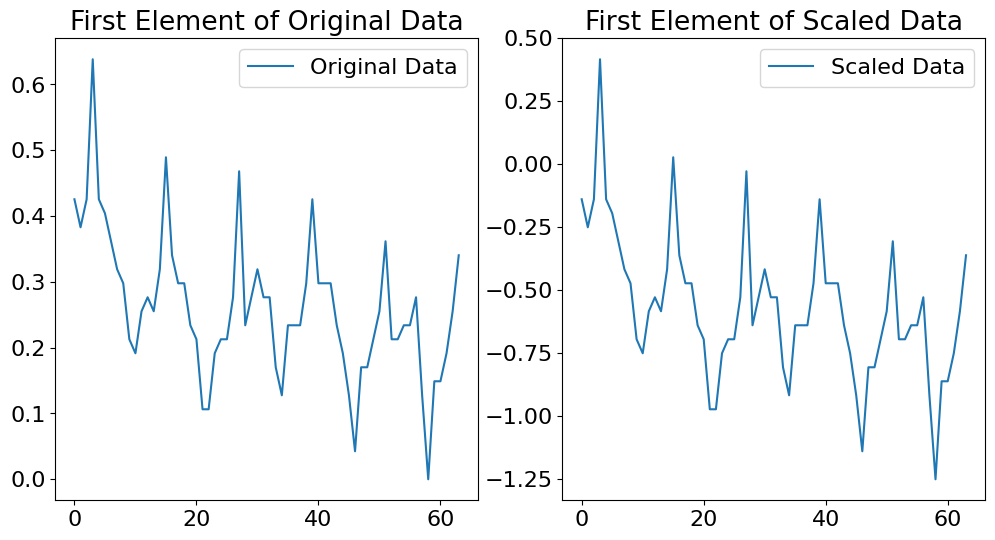

In [ ]:
import matplotlib.pyplot as plt
selected_series=3
# Ottieni gli indici di inizio e fine del periodo valido per la serie selezionata
start_index, end_index = valid_periods[selected_series]
# Estrai la parte dei dati di addestramento compresa tra i periodi validi
original_series = train_data[selected_series, start_index:]

# Primo elemento di scaled_train_data
scaled_series = scaled_train_data[selected_series, start_index:]

# Plot del primo elemento di train_data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(original_series, label='Original Data')
plt.title('First Element of Original Data')
plt.legend()

# Plot del primo elemento di scaled_train_data
plt.subplot(1, 2, 2)
plt.plot(scaled_series, label='Scaled Data')
plt.title('First Element of Scaled Data')
plt.legend()

plt.show()


#####Build sequence

In [ ]:
def build_sequences(data, valid_periods, categories, window=200, stride=20, telescope=100):
    assert window % stride == 0

    dataset = []
    labels = []
    category_labels = []

    # Iterate over each time series
    for idx in range(len(data)):
        series_data = data[idx]
        series_valid_periods = valid_periods[idx]
        series_category = categories[idx]

        # Start building sequences from the first valid period
        start_index = series_valid_periods[0]

        # Pad the series if needed
        padding_check = (len(series_data) - start_index) % window
        if padding_check != 0:
            start_index -= window - padding_check

        # Build sequences for the current time series
        for i in range(start_index, len(series_data) - window - telescope, stride):
            dataset.append(series_data[i:i + window])
            labels.append(series_data[i + window:i + window + telescope])
            category_labels.append(series_category)

    # Convert lists to numpy arrays
    dataset = np.array(dataset)
    labels = np.array(labels)
    category_labels = np.array(category_labels)

    return dataset, labels, category_labels

In [ ]:
window = 40
stride = 1
telescope = 18

X_train_short, y_train_short, category_train_labels_short = build_sequences(train_data_short, train_valid_periods_short, train_categories_short, window, stride, telescope)
X_test_short, y_test_short, category_test_labels_short = build_sequences(test_data_short, test_valid_periods_short, test_categories_short, window, stride, telescope)
X_val_short, y_val_short, category_val_labels_short = build_sequences(val_data_short, val_valid_periods_short, val_categories_short, window, stride, telescope)

X_train_short.shape, y_train_short.shape, category_train_labels_short.shape, X_test_short.shape, y_test_short.shape, category_test_labels_short.shape, X_val_short.shape, y_val_short.shape, category_val_labels_short.shape

((1772688, 40),
 (1772688, 18),
 (1772688,),
 (50736, 40),
 (50736, 18),
 (50736,),
 (46924, 40),
 (46924, 18),
 (46924,))

In [ ]:
window = 100
stride = 5
telescope = 18

X_train_long, y_train_long, category_train_labels_long = build_sequences(train_data_long, train_valid_periods_long, train_categories_long, window, stride, telescope)
X_test_long, y_test_long, category_test_labels_long = build_sequences(test_data_long, test_valid_periods_long, test_categories_long, window, stride, telescope)
X_val_long, y_val_long, category_val_labels_long = build_sequences(val_data_long, val_valid_periods_long, val_categories_long, window, stride, telescope)

X_train_long.shape, y_train_long.shape, category_train_labels_long.shape, X_test_long.shape, y_test_long.shape, category_test_labels_long.shape, X_val_long.shape, y_val_long.shape, category_val_labels_long.shape

((1199919, 100),
 (1199919, 18),
 (1199919,),
 (32272, 100),
 (32272, 18),
 (32272,),
 (31605, 100),
 (31605, 18),
 (31605,))

In [ ]:
X_train, y_train, category_train_labels = build_sequences(train_data, train_valid_periods, train_categories, window, stride, telescope)
X_test, y_test, category_test_labels = build_sequences(test_data, test_valid_periods, test_categories, window, stride, telescope)
X_val, y_val, category_val_labels = build_sequences(val_data, val_valid_periods, val_categories, window, stride, telescope)

X_train.shape, y_train.shape, category_train_labels.shape, X_test.shape, y_test.shape, category_test_labels.shape, X_val.shape, y_val.shape, category_val_labels.shape

((1193789, 100),
 (1193789, 18),
 (1193789,),
 (32680, 100),
 (32680, 18),
 (32680,),
 (30741, 100),
 (30741, 18),
 (30741,))

In [ ]:
# Mescola gli indici delle sequenze
indices = np.arange(len(X_train))
np.random.shuffle(indices)

# Applica lo stesso shuffle sia a X_train che a y_train e category_train_labels
X_train = X_train[indices]
y_train = y_train[indices]
category_train_labels= category_train_labels[indices]

In [ ]:
# Mescola gli indici delle sequenze
long_idxs = np.arange(len(X_train_long))
np.random.shuffle(long_idxs)

short_idxs = np.arange(len(X_train_short))
np.random.shuffle(short_idxs)

# Applica lo stesso shuffle sia a X_train che a y_train e category_train_labels
X_train_long = X_train_long[long_idxs]
y_train_long = y_train_long[long_idxs]
category_train_labels_long = category_train_labels_long[long_idxs]

X_train_short = X_train_short[short_idxs]
y_train_short = y_train_short[short_idxs]
category_train_labels_short = category_train_labels_short[short_idxs]

In [ ]:
import matplotlib.pyplot as plt

def inspect_univariate(X, y, telescope, idx=None):
    if idx is None:
        idx = np.random.randint(0, len(X))  # seleziona un indice casualmente

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(np.arange(len(X[idx])), X[idx])
    ax.scatter(np.arange(len(X[idx]), len(X[idx]) + telescope), y[idx], color='orange')
    ax.set_title('Univariate Time Series')
    ax.set_ylim(0, 1)
    #ax.set_ylim(-3, 3)
    plt.show()


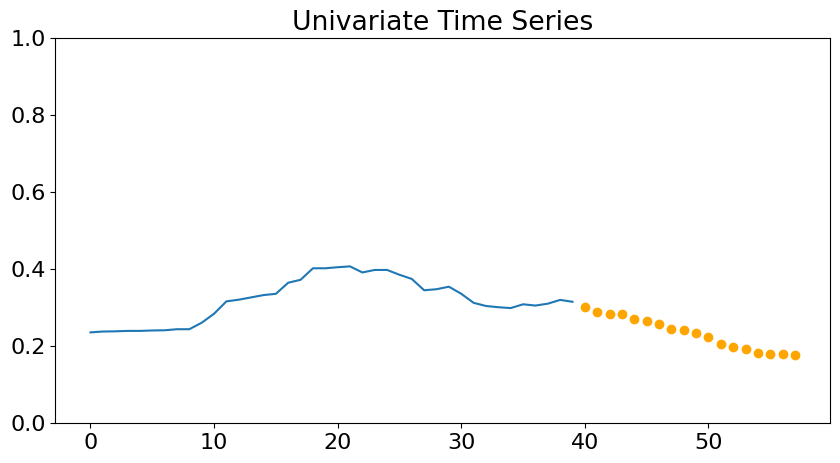

In [ ]:
inspect_univariate(X_train_short, y_train_short, telescope)

###Train

In [ ]:
# Aggiungi una dimensione ai tuoi array
X_train = np.expand_dims(X_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
print(X_train.shape), print(y_train.shape)

(1193789, 100, 1)
(1193789, 18, 1)


(None, None)

In [ ]:
# Aggiungi una dimensione ai tuoi array
X_train_short = np.expand_dims(X_train_short, axis=-1)
y_train_short = np.expand_dims(y_train_short, axis=-1)
print(X_train_short.shape), print(y_train_short.shape)

# Aggiungi una dimensione ai tuoi array
X_train_long = np.expand_dims(X_train_long, axis=-1)
y_train_long = np.expand_dims(y_train_long, axis=-1)
print(X_train_long.shape), print(y_train_long.shape)

(1772688, 40, 1)
(1772688, 18, 1)
(1199919, 100, 1)
(1199919, 18, 1)


(None, None)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 256
epochs = 200

In [ ]:
print(input_shape)
print(output_shape)

(100, 1)
(18, 1)


####Basic Model

In [ ]:
input_shape = X_train_short.shape[1:]
output_shape = y_train_short.shape[1:]

In [ ]:
input_shape = X_train_long.shape[1:]
output_shape = y_train_long.shape[1:]

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)
    #nota: ORA È IMPORTANTE CHE SIA TRUE (NON SI CAPISCE PERCHE,  CHIEDERE)

    x = tfkl.LSTM(64, return_sequences=True, name='lstm1')(x)


    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length [RICHIEDERE: DICE CHE CI SONO DIVERSI MODI PER FARLO ...]
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 40, 1)]           0         
                                                                 
 bidirectional_lstm (Bidire  (None, 40, 128)           33792     
 ctional)                                                        
                                                                 
 lstm1 (LSTM)                (None, 40, 64)            49408     
                                                                 
 conv (Conv1D)               (None, 40, 128)           24704     
                                                                 
 output_layer (Conv1D)       (None, 40, 1)             385       
                                                                 
 cropping (Cropping1D)       (None, 18, 1)             0         
                                                   

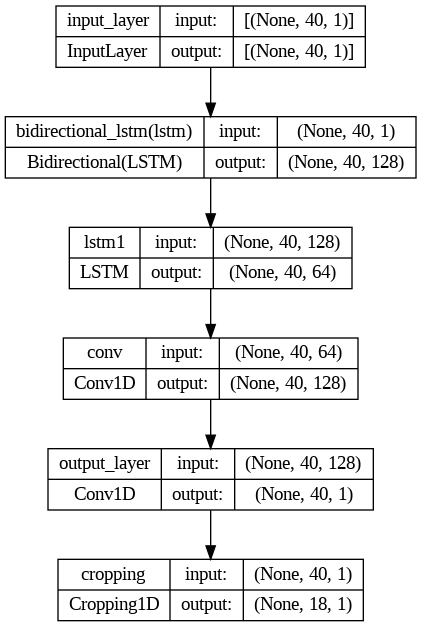

In [ ]:
basic_model = build_CONV_LSTM_model(input_shape, output_shape)
basic_model.summary()
tfk.utils.plot_model(basic_model, expand_nested=True, show_shapes=True)

In [ ]:
batch_size = 1024
epochs = 200

In [ ]:
# Train the model
history = basic_model.fit(
    x = X_train_short, #change length
    y = y_train_short, #change length
    batch_size = batch_size,
    epochs = epochs,
    validation_data=[X_val_short,y_val_short], #change length
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=6, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=4, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
1732/1732 [==============================] - 50s 25ms/step - loss: 0.0193 - val_loss: 0.0175 - lr: 0.0010
Epoch 2/200
1732/1732 [==============================] - 42s 24ms/step - loss: 0.0163 - val_loss: 0.0169 - lr: 0.0010
Epoch 3/200
1732/1732 [==============================] - 42s 24ms/step - loss: 0.0156 - val_loss: 0.0160 - lr: 0.0010
Epoch 4/200
1732/1732 [==============================] - 42s 24ms/step - loss: 0.0149 - val_loss: 0.0159 - lr: 0.0010
Epoch 5/200
1732/1732 [==============================] - 42s 24ms/step - loss: 0.0144 - val_loss: 0.0151 - lr: 0.0010
Epoch 6/200
1732/1732 [==============================] - 41s 24ms/step - loss: 0.0140 - val_loss: 0.0155 - lr: 0.0010
Epoch 7/200
1732/1732 [==============================] - 41s 24ms/step - loss: 0.0137 - val_loss: 0.0146 - lr: 0.0010
Epoch 8/200
1732/1732 [==============================] - 41s 24ms/step - loss: 0.0134 - val_loss: 0.0144 - lr: 0.0010
Epoch 9/200
1732/1732 [==============================] -

In [ ]:
basic_model.save('long_model')

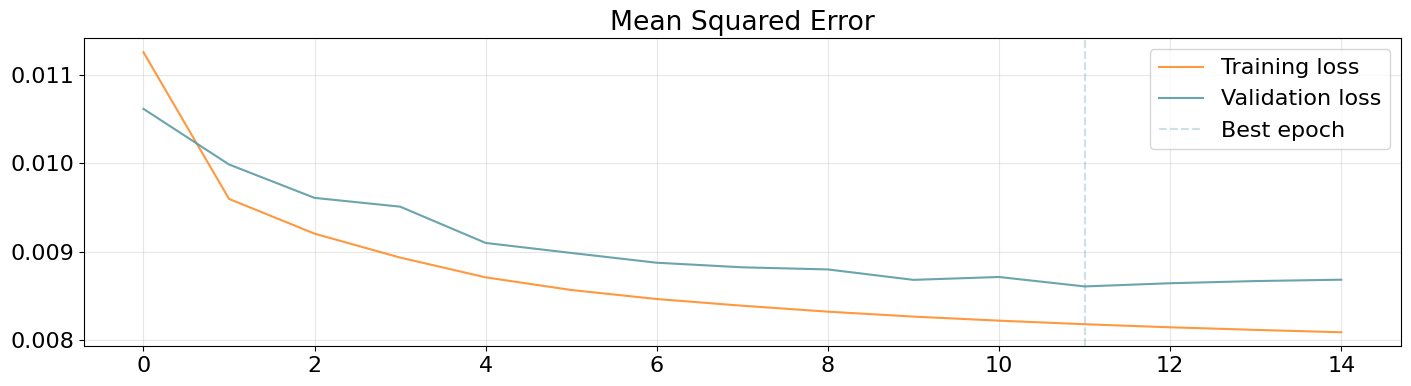

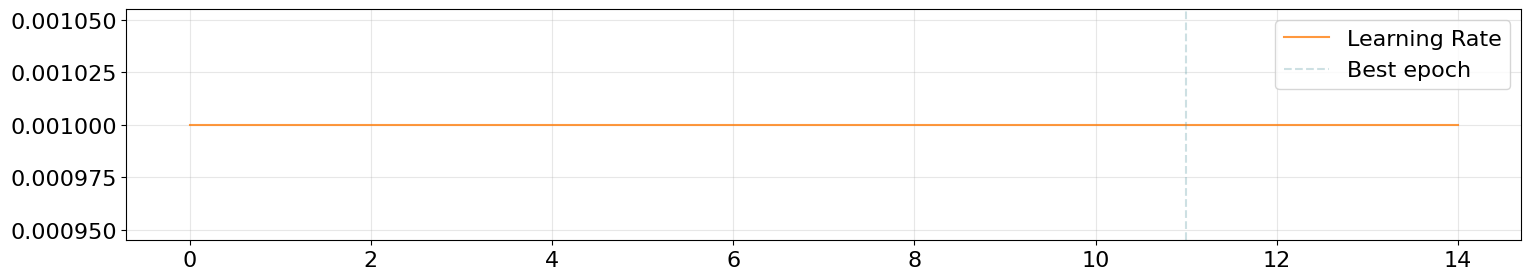

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

####Easy Model

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)
    #nota: ORA È IMPORTANTE CHE SIA TRUE (NON SI CAPISCE PERCHE,  CHIEDERE)

    x = tfkl.LSTM(64, return_sequences=True, name='lstm1')(x)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length [RICHIEDERE: DICE CHE CI SONO DIVERSI MODI PER FARLO ...]
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 1)]          0         
                                                                 
 bidirectional_lstm (Bidire  (None, 200, 128)          33792     
 ctional)                                                        
                                                                 
 lstm1 (LSTM)                (None, 200, 64)           49408     
                                                                 
 conv (Conv1D)               (None, 200, 128)          24704     
                                                                 
 output_layer (Conv1D)       (None, 200, 1)            385       
                                                                 
 cropping (Cropping1D)       (None, 9, 1)              0         
                                                   

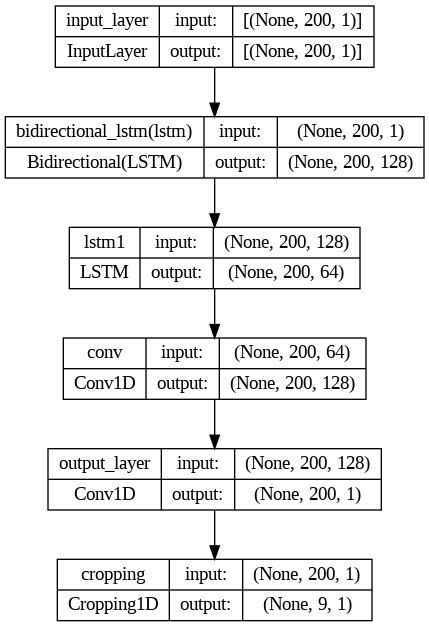

In [ ]:
easy_model = build_CONV_LSTM_model(input_shape, output_shape)
easy_model.summary()
tfk.utils.plot_model(easy_model, expand_nested=True, show_shapes=True)

In [ ]:
batch_size = 2056
epochs = 200

In [ ]:
# Train the model
history = easy_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=[X_val,y_val],
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=6, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=4, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
439/439 [==============================] - 97s 209ms/step - loss: 0.0671 - val_loss: 0.0594 - lr: 0.0010
Epoch 2/200
 30/439 [=>............................] - ETA: 1:18 - loss: 0.0642

KeyboardInterrupt: ignored

In [ ]:
easy_model.save('easy_model')

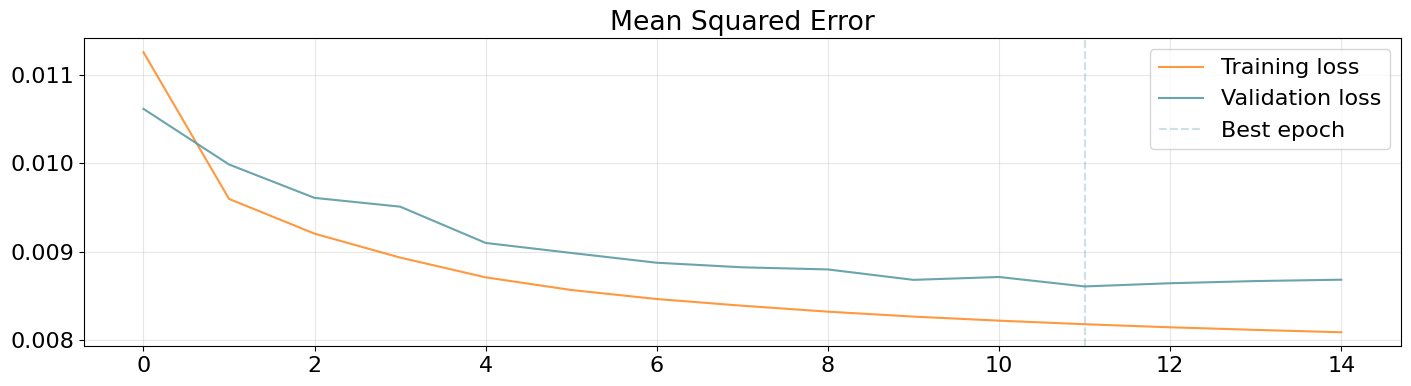

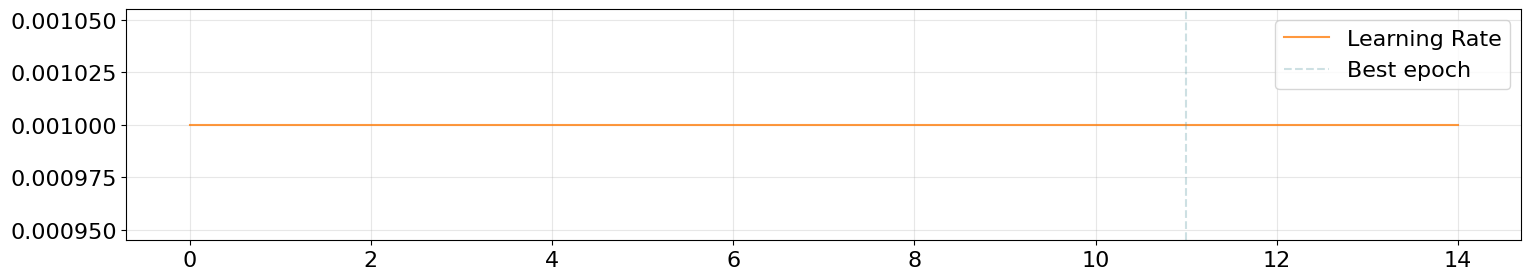

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

####Attention Model

In [ ]:
pip install attention

In [ ]:
from attention import Attention

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    #masking_layer = tfkl.Masking(mask_value=0.0)(input_layer)
    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add an Attention layer
    attention_output = tfkl.Attention(use_scale=True)([x, x])

    # Concatenate the output of the attention layer with the LSTM output
    x = tf.concat([x, attention_output], axis=-1)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model


In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)
    
    # GRU instead of LSTM
    #x = tfkl.Bidirectional(tfkl.GRU(64, return_sequences=True, name='gru'), name='bidirectional_gru')(input_layer)

    attention_out = Attention(32)(x)
    outputs = tfkl.Dense(9)(attention_out)
    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=outputs, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())
    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 40, 1)]           0         
                                                                 
 bidirectional_lstm (Bidire  (None, 40, 128)           33792     
 ctional)                                                        
                                                                 
 attention_4 (Attention)     (None, 32)                24576     
                                                                 
 dense_2 (Dense)             (None, 9)                 297       
                                                                 
Total params: 58665 (229.16 KB)
Trainable params: 58665 (229.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


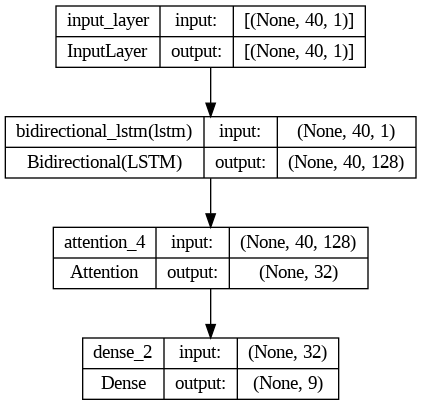

In [ ]:
easy_model = build_CONV_LSTM_model(input_shape, output_shape)
easy_model.summary()
tfk.utils.plot_model(easy_model, expand_nested=True, show_shapes=True)

In [ ]:
batch_size = 128
epochs = 200

In [ ]:
# Train the model
history = easy_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=[X_val,y_val],
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=6, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=4, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/200
55178/55178 [==============================] - 485s 9ms/step - loss: 0.0090 - val_loss: 0.0082 - lr: 0.0010
Epoch 2/200
55178/55178 [==============================] - 480s 9ms/step - loss: 0.0081 - val_loss: 0.0079 - lr: 0.0010
Epoch 3/200
55178/55178 [==============================] - 483s 9ms/step - loss: 0.0078 - val_loss: 0.0078 - lr: 0.0010
Epoch 4/200
55178/55178 [==============================] - 474s 9ms/step - loss: 0.0077 - val_loss: 0.0077 - lr: 0.0010
Epoch 5/200
 1660/55178 [..............................] - ETA: 7:31 - loss: 0.0077

KeyboardInterrupt: ignored

In [ ]:
easy_model.save('attentionnew_model')

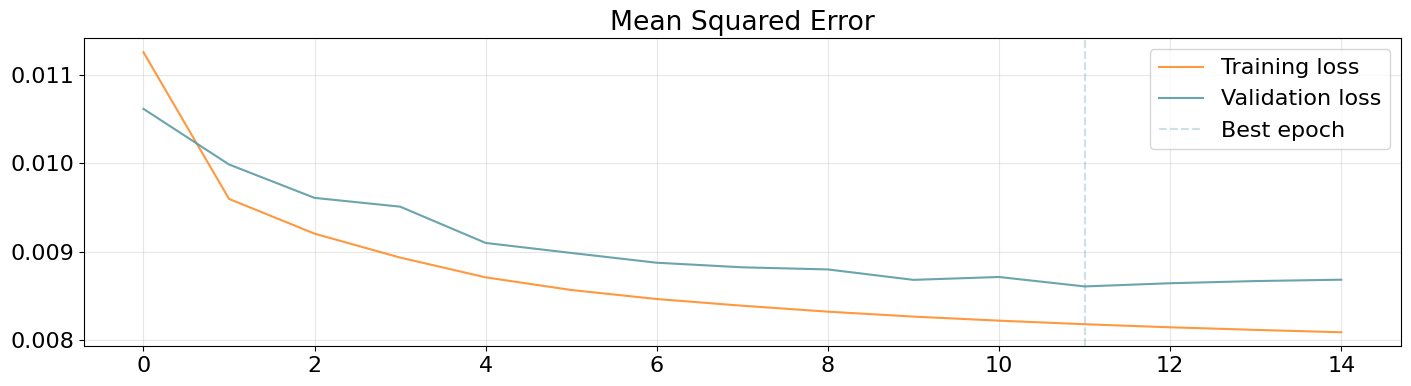

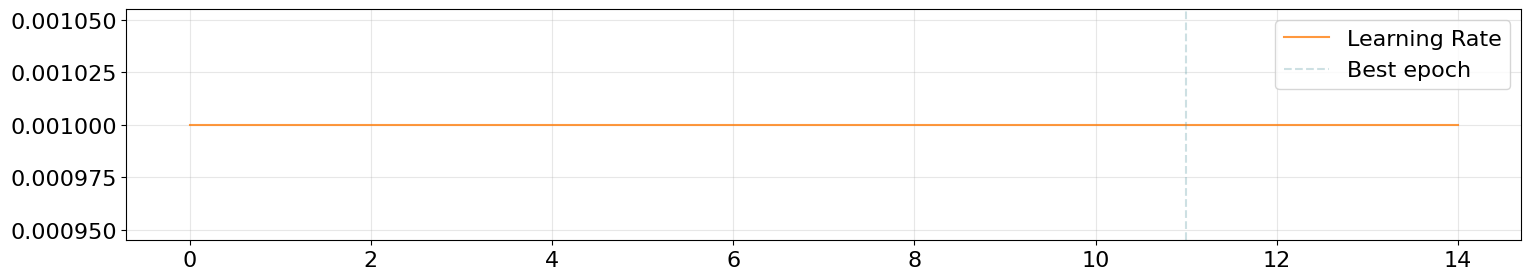

In [ ]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

###Prediction

In [ ]:
def inspect_univariate_prediction(X, y, pred, telescope, idx=None):
    if idx is None:
        idx = np.random.randint(0, len(X))
        print(idx)

    pred = np.concatenate([np.expand_dims(X[:, -1], axis=1), pred.squeeze()], axis=1)
    y = np.concatenate([np.expand_dims(X[:, -1], axis=1), y.squeeze()], axis=1)

    fig, ax = plt.subplots(figsize=(17, 5))
    ax.plot(np.arange(len(X[0])), X[idx])
    ax.plot(np.arange(len(X[0]) - 1, len(X[0]) + telescope), y[idx], color='orange')
    ax.plot(np.arange(len(X[0]) - 1, len(X[0]) + telescope), pred[idx], color='green')
    ax.set_title('Prediction vs Actual')
    ax.set_ylim(0, 1)
    plt.show()

In [ ]:
# model.save('DirectForecasting')
model = tfk.models.load_model('attentionnew_model')

In [ ]:
model=easy_model

In [ ]:
short_model = tfk.models.load_model('short_model')

In [ ]:
long_model = tfk.models.load_model('long_model')

In [ ]:
# Predict the test set using the model
predictions = model.predict(X_test, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (32680, 18, 1)
Mean Squared Error: 0.011733355931937695
Mean Absolute Error: 0.07474104315042496


In [ ]:
# Predict the test set using the model
short_predictions = short_model.predict(X_test_short, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {short_predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test_short.flatten(), short_predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test_short.flatten(), short_predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (50736, 18, 1)
Mean Squared Error: 0.010482151992619038
Mean Absolute Error: 0.06965836882591248


6296


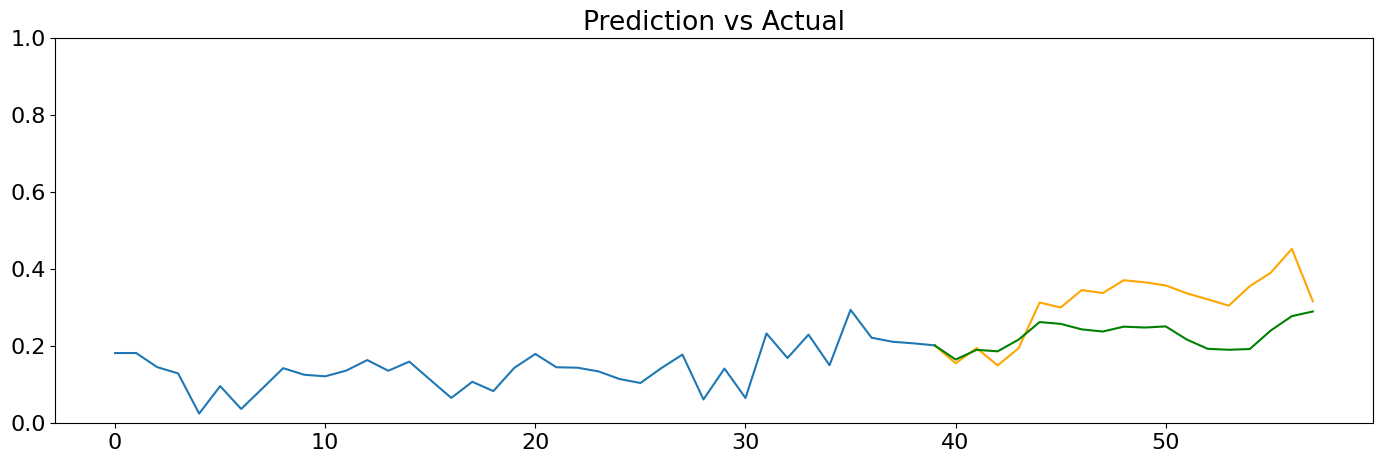

In [ ]:
inspect_univariate_prediction(X_test_short, y_test_short, short_predictions, telescope)

In [ ]:
# Predict the test set using the model
long_predictions = long_model.predict(X_test_long, verbose=0)

# Print the shape of the predictions
print(f"Predictions shape: {long_predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test_long.flatten(), long_predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test_long.flatten(), long_predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (32272, 18, 1)
Mean Squared Error: 0.009898629039525986
Mean Absolute Error: 0.06602464616298676


13082


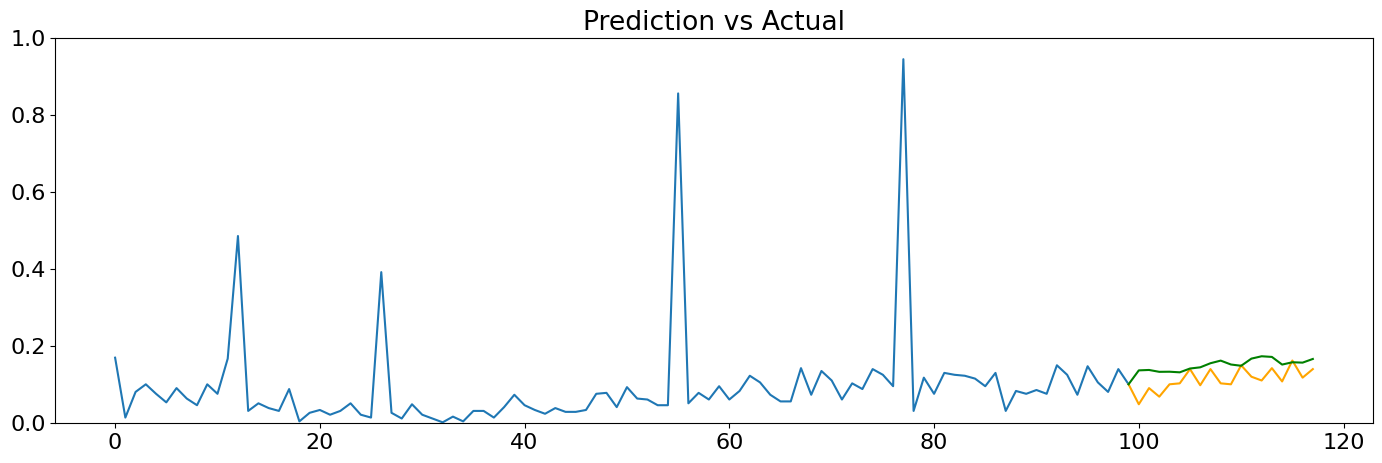

In [ ]:
inspect_univariate_prediction(X_test_long, y_test_long, long_predictions, telescope)

In [ ]:
#JOINT PREDICTION on X_test_long
#doing the mean of the 2 model data
# Predict the test set using the model
joint_predictions = short_model.predict(X_test_long[:, -40:], verbose=0)

joint_predictions = (joint_predictions + long_predictions) / 2

# Print the shape of the predictions
print(f"Predictions shape: {joint_predictions.shape}")
#009700735099613667
# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test_long.flatten(), joint_predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test_long.flatten(), joint_predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (32272, 18, 1)
Mean Squared Error: 0.009207007475197315
Mean Absolute Error: 0.0636511817574501


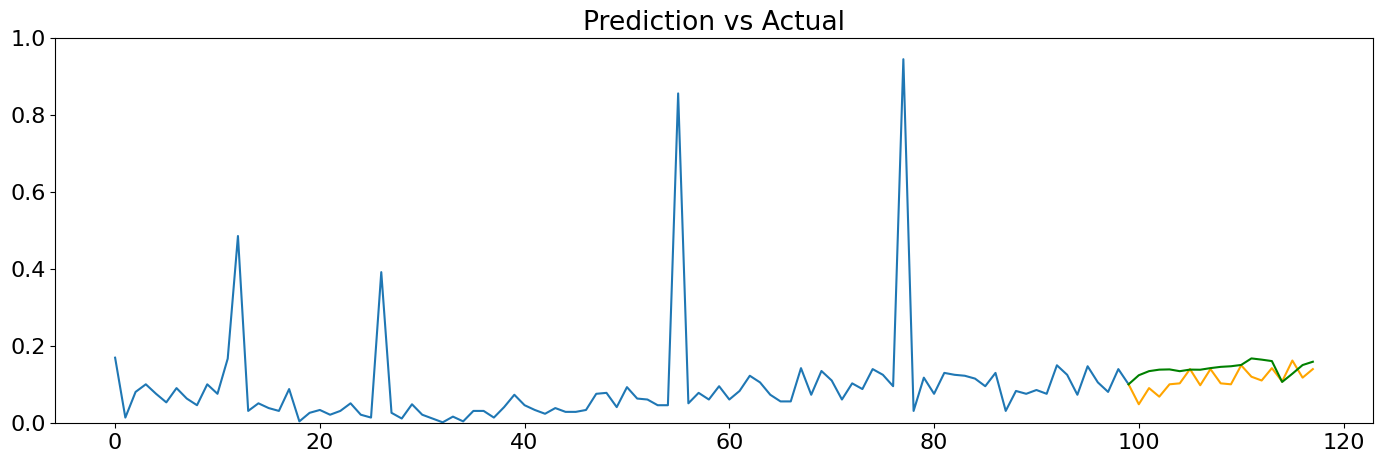

In [ ]:
inspect_univariate_prediction(X_test_long, y_test_long, joint_predictions, telescope,13082)

In [ ]:
X_test.shape, y_test.shape, predictions.shape

((32680, 100), (32680, 18), (32680, 18, 1))

In [ ]:
inspect_univariate_prediction(X_test, y_test, predictions, telescope)

NameError: ignored